### Task 154: V2 liquidity fix
* k: constant product (ie, x*y = k)
* R0: Reserve0
* R1: Reserve1
* Ai: Amount of input token 
* Ao: Amount of output token 

#### Mathematical Mapping Legend
* reserveIn (R1) -> x
* reserveOut (R0) -> y
* amountIn (Ai) -> $\Delta$x
* amountOut (Ao) -> $\Delta$y
* 1 - swap fee -> r = (1 - 0.003) or (997/1000)

In [4]:
9999999999999999000/1e18

10.0

In [1]:
def getSci(flt):
    str_vals = str(flt).split('e')
    coef = float(str_vals[0])
    exp = int(str_vals[1])
    return_val = ''
    if int(exp) > 0:
        return_val += str(coef).replace('.', '')
        return_val += ''.join(['0' for _ in range(0, abs(exp - len(str(coef).split('.')[1])))])
    elif int(exp) < 0:
        return_val += '0.'
        return_val += ''.join(['0' for _ in range(0, abs(exp) - 1)])
        return_val += str(coef).replace('.', '')
    return return_val

In [2]:
from IPython.display import Image
import numpy as np
import os
cwd =  os.getcwd().replace("notebooks/contracts","")
os.chdir(cwd)

### References
* [Reference Example](https://betterprogramming.pub/uniswap-v2-in-depth-98075c826254)
* [Function swap in v2 core](https://github.com/Uniswap/v2-core/blob/master/contracts/UniswapV2Pair.sol#L159)
* [Functions getAmountsOut and getAmountsIn in v2 periphery](https://github.com/Uniswap/v2-periphery/blob/master/contracts/libraries/UniswapV2Library.sol)
* [Uniswap V2 Protocol: tutorial #1](https://betterprogramming.pub/uniswap-v2-in-depth-98075c826254)
* [Uniswap V2 Protocol: tutorial #2](https://segmentfault.com/a/1190000041859308/en)
* [Uniswap V2 Protocol: tutorial #3](https://ethereum.org/ka/developers/tutorials/uniswap-v2-annotated-code/)
* [Detailed annotated contract output](https://docs.google.com/spreadsheets/d/1oy2A4CgRL2l61sLAwc4J1utvZkC-nC8iFLZgNjJ2tSY/edit#gid=0)

#### Mathematical Expose
Let’s recall the constant product formula:<br>
> x*y = k 

Where x and y are pair reserves (reserve0 and reserve1). When doing a swap, x and y are changed but k remains the same (or, actually, it grows slowly thanks to swap fees). We can write this as a formula:
> (x+rΔx)(y−Δy)=xy

Where r is 1 - swap fee (1 - 0.3% = 0.997),  $\Delta$x is the amount we give into the exchange for the $\Delta$y amount we get in return. <br>

This is a very nice and concise formula that shows that the product of reserves after a swap must be equal to the product of reserves before the swap, which is the definition of the constant product formula. And we can use this formula to calculate the amount we get during a swap. After doing some basic algebraic operations, we get this:
> $\Delta$y = $\frac{yr\Delta x}{x+r \Delta x}$

As you can see, this is a relation of two reserves (y/x) that takes into consideration the input amount (r$\Delta$x), including the fee.

Let’s program this out:

In [3]:
amountIn = 414375000000000000/1e18
reserveIn = 12585625000000000000/1e18
reserveOut = 15490000000000000000/1e18
amountInWithFee = amountIn*997
numerator = amountInWithFee*reserveOut
denominator = reserveIn*1000 + amountInWithFee
amountOut = numerator/denominator
amountOut

0.4923095958551037

In [4]:
amountIn = 473967451457258139/1e18
reserveIn = 12526032548542741861/1e18
reserveOut = 15416655444360297674/1e18
amountInWithFee = amountIn*997
numerator = amountInWithFee*reserveOut
denominator = reserveIn*1000 + amountInWithFee
amountOut = numerator/denominator
amountOut

0.560451447655244

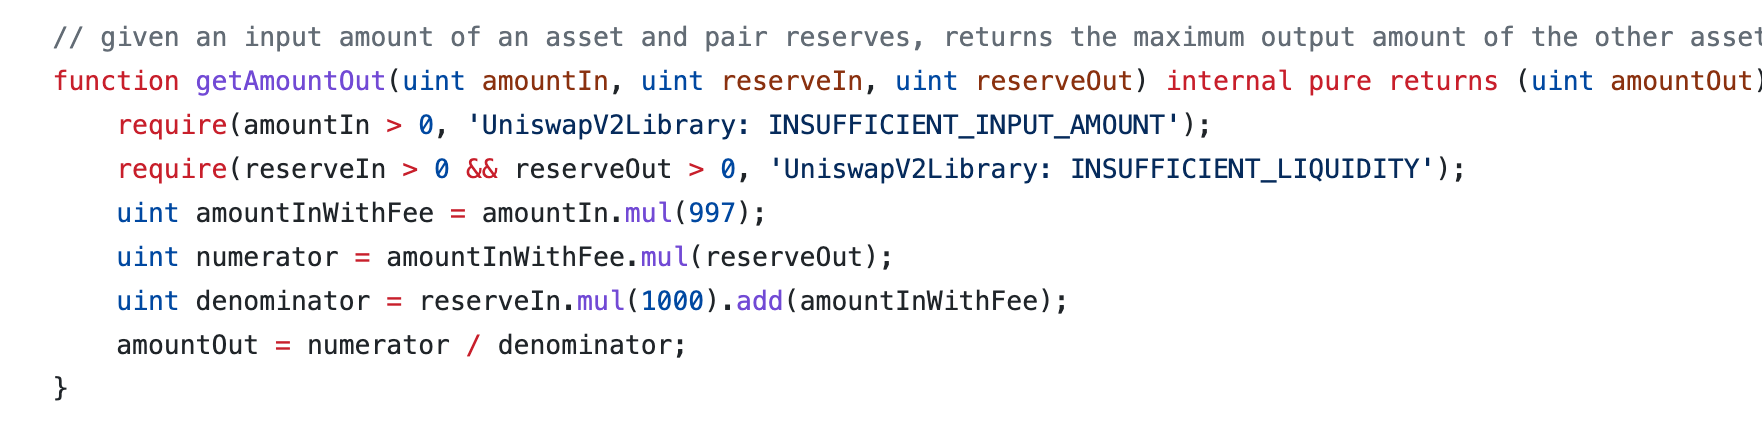

In [5]:
Image("images/jupyter/uniswap_v2/getAmountOut.png",  width = 900, height = 200)

[See function getAmountsOut on line 42 in uniswap v2 periphery](https://github.com/Uniswap/v2-periphery/blob/master/contracts/libraries/UniswapV2Library.sol#L42)

Above, we see amountIn is $\Delta$x, reserveIn is x, reserveOut is y. Because of Solidity not supporting float point division, we need to multiply numerator and denominator by 1000 and then subtract 3 from the multiplier applied to amountIn–this will apply the 0.3% fee to amountIn:

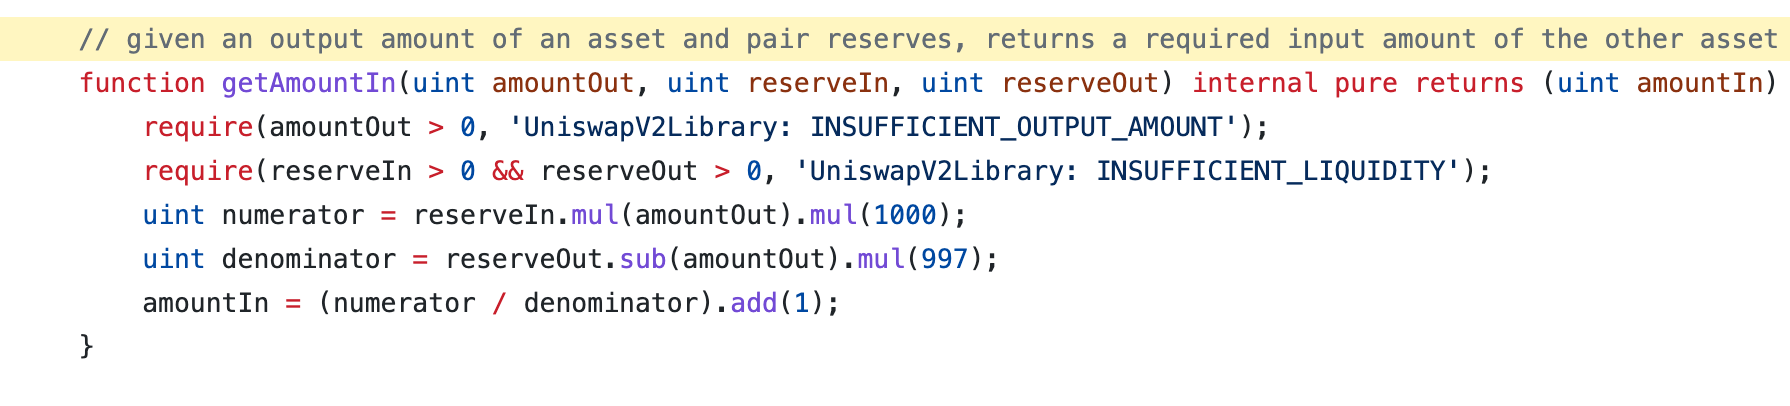

In [6]:
Image("images/jupyter/uniswap_v2/getAmountIn.png",  width = 900, height = 200)

[See function getAmountsIn on line 52 in uniswap v2 periphery](https://github.com/Uniswap/v2-periphery/blob/master/contracts/libraries/UniswapV2Library.sol#L52)

Now we can proceed with swapping.

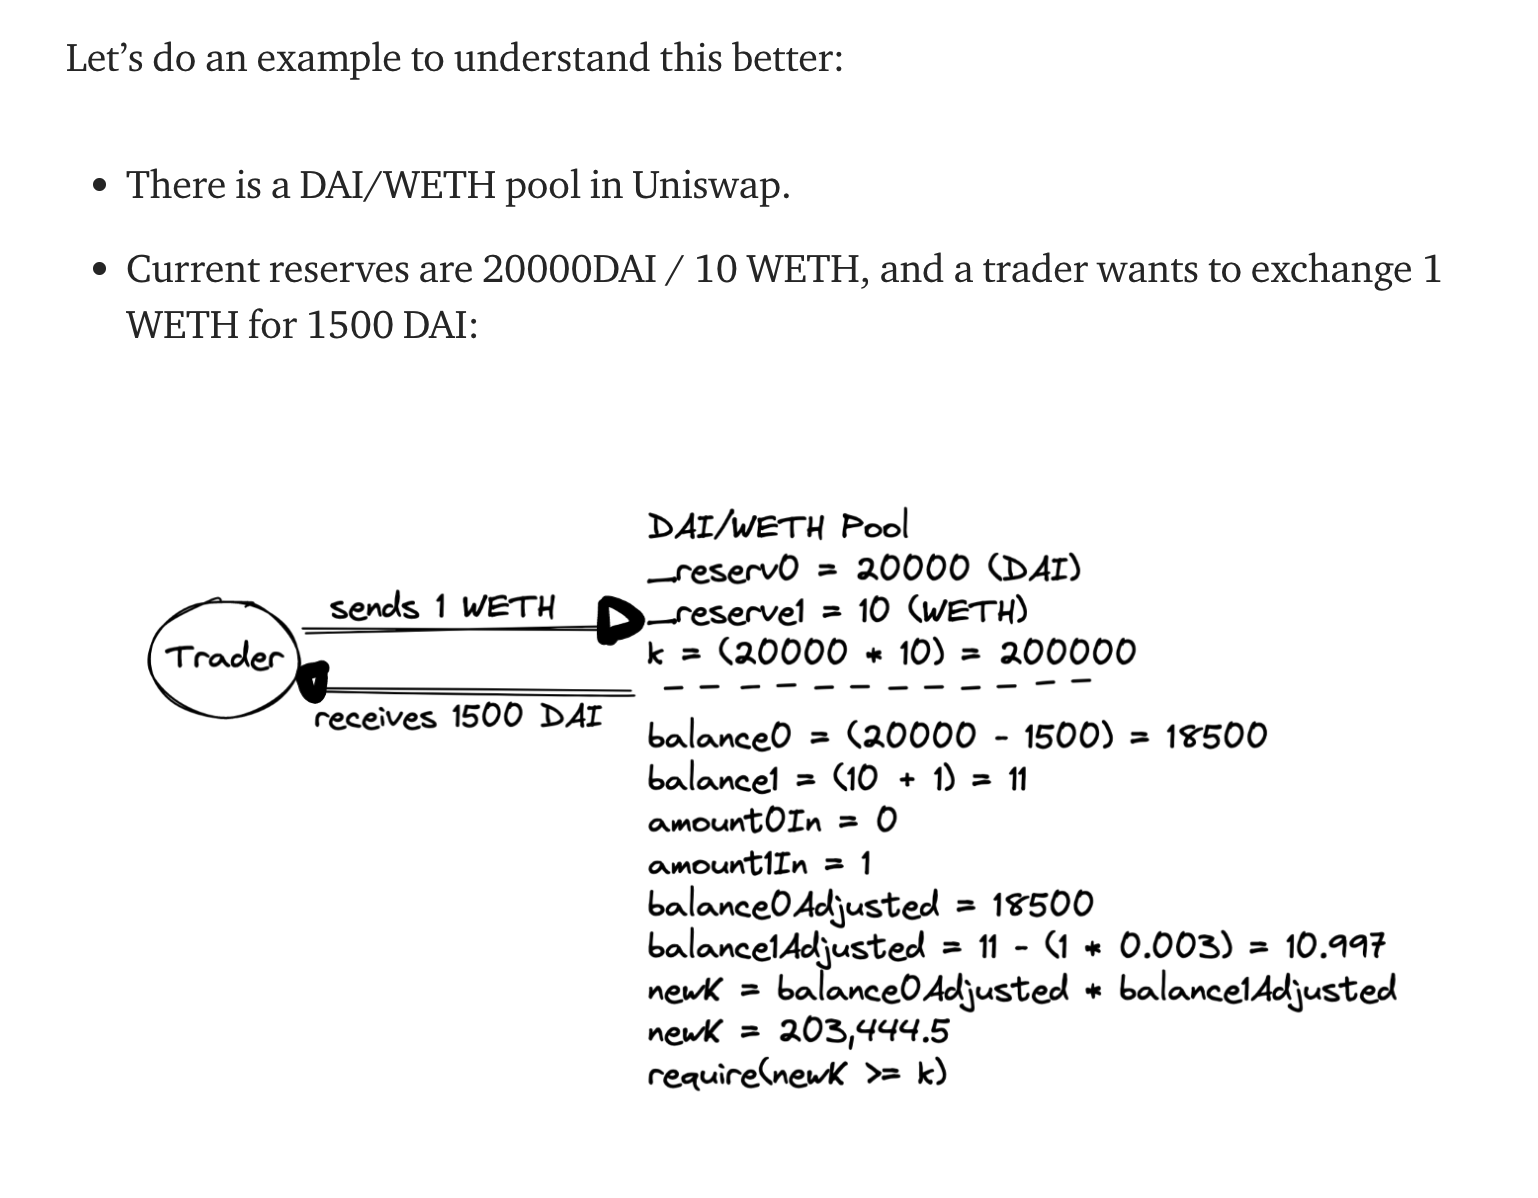

In [7]:
Image("images/jupyter/uniswap_v2/example.png", width = 600, height = 600)

### Initial Problem setup

We will send 1 WETH and get 1500 DAI; the original reserves are 20000 DAI and 10 WETH

In [8]:
9999000000000000000000/1e18

9999.0

In [9]:
Ai = 1; Ao = 1500

print('We swap {} WETH to get {} DIA'.format(Ai,Ao))

We swap 1 WETH to get 1500 DIA


In [10]:
R0 = 20000; R1 = 10

print('Original reserve of {} DIA and {} WETH'.format(R0, R1))

Original reserve of 20000 DIA and 10 WETH


### Run simplified swap

First, calculate balances

In [11]:
k = R0*R1
bal0 = R0 - Ao
bal1 = R1 + Ai

Then calculate adjusted balances

In [12]:
A0i = 0 
A1i = 1
bal0Adj = bal0*1000-A0i*3

print('Adjusted R0 after swap: {}'.format(bal0Adj/1000))

Adjusted R0 after swap: 18500.0


In [13]:
bal1Adj = bal1*1000-A1i*3

print('Adjusted R1 after swap: {}'.format(bal1Adj/1000))

Adjusted R1 after swap: 10.997


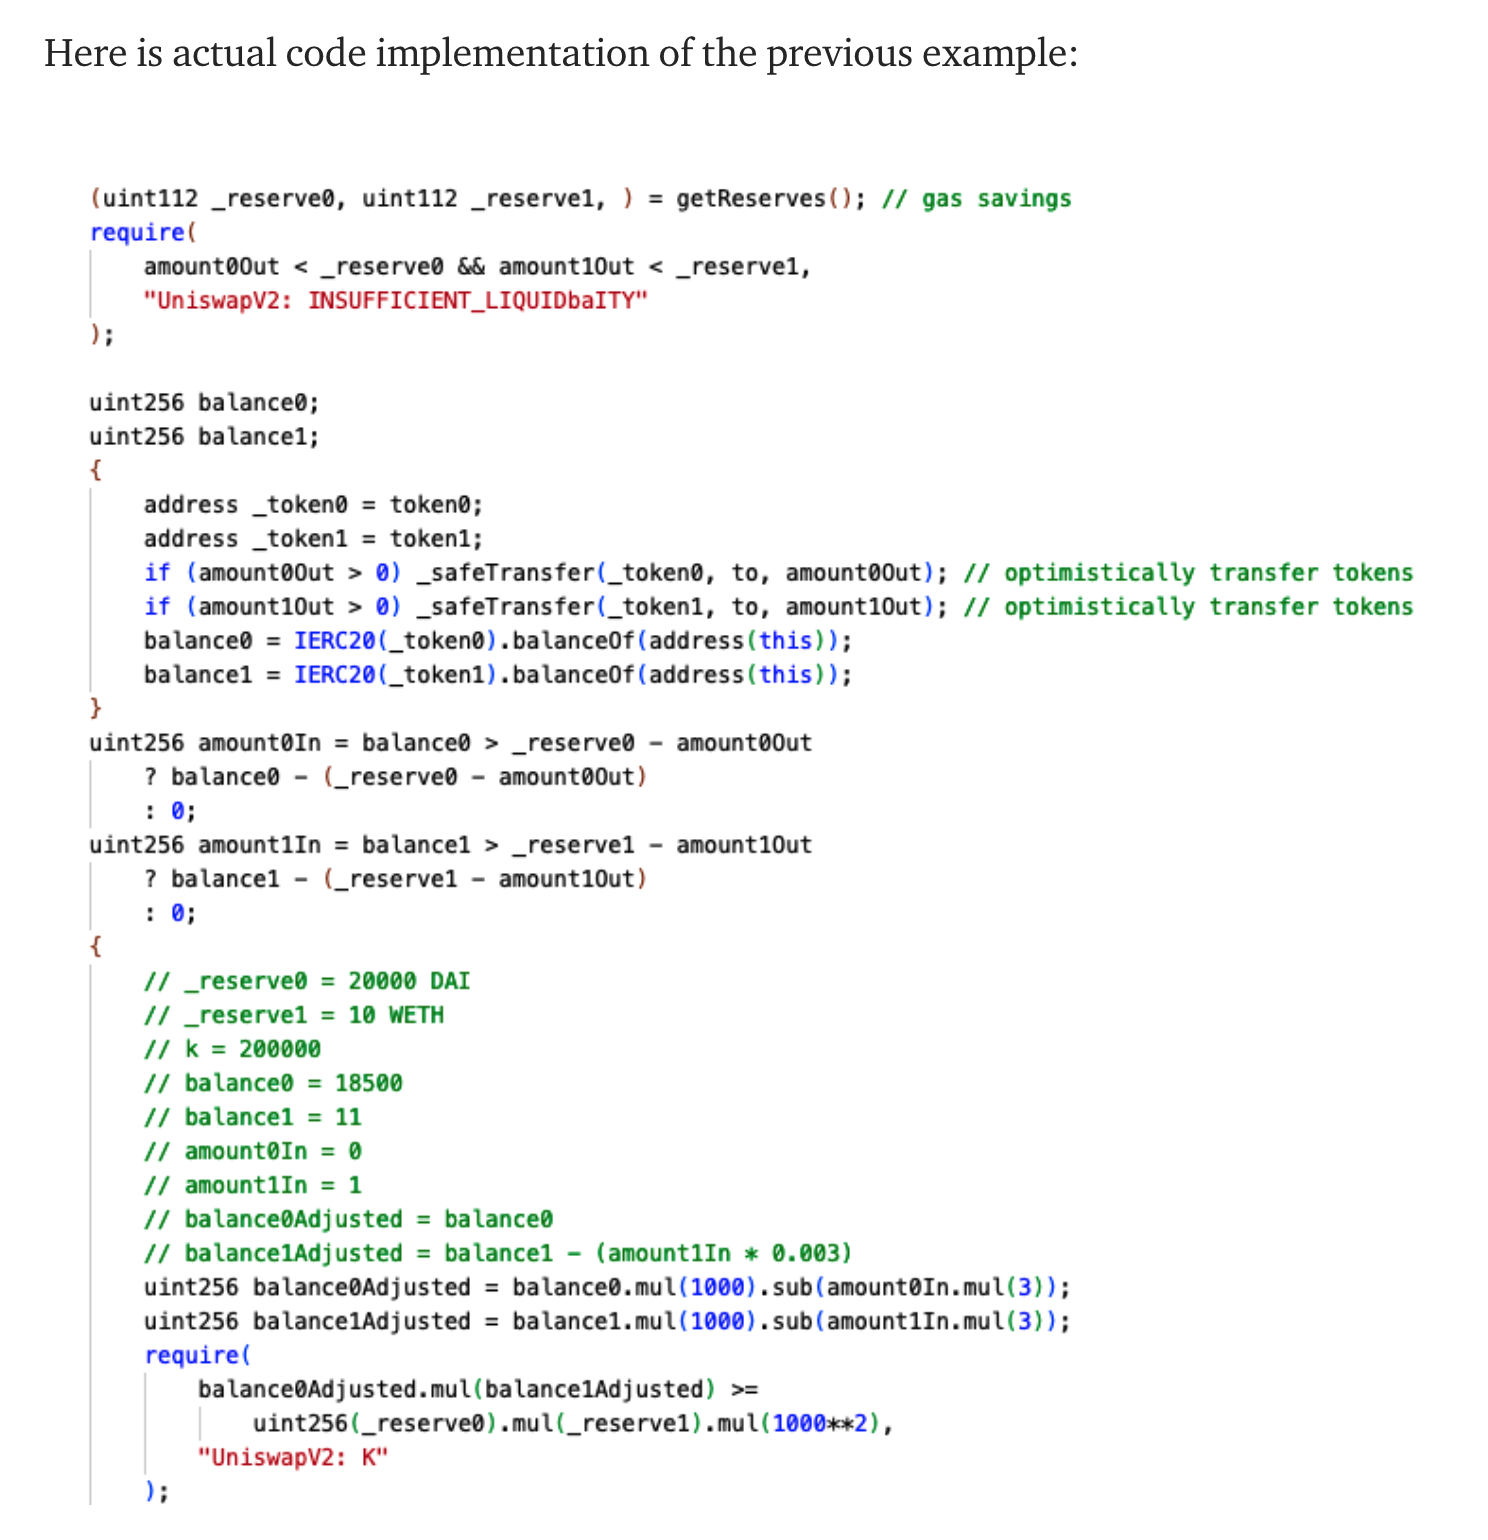

In [14]:
Image("images/jupyter/uniswap_v2/example_code.png", width = 600, height = 600)

[See function swap on line 159 in uniswap v2 core](https://github.com/Uniswap/v2-core/blob/master/contracts/UniswapV2Pair.sol#L159)

### Part 1: Perform complete swap

The above swap is a simplifcation, next we must factor getting the maximum amount of tokens that you can get for a given input. First we determing amount out accordance to [function getAmountOut on line 42 in uniswap v2 periphery](https://github.com/Uniswap/v2-periphery/blob/master/contracts/libraries/UniswapV2Library.sol#L42) (or see above for code snippet) 

In [15]:
def getAmountOut(Ai,Ro,Ri):
    return (Ro*997*Ai)/(Ri*1000 + Ai*997)

Then we get amount in accordance to [function getAmountIn on line 52 in uniswap v2 periphery](https://github.com/Uniswap/v2-periphery/blob/master/contracts/libraries/UniswapV2Library.sol#L52) (or see above for code snippet)

In [16]:
def getAmountIn(Ao,Ro,Ri):
    return (Ri*1000*Ao)/(997*(Ro-Ao))

Next, we calculated the amount out in accordance to our input of 1 WETH

In [17]:
Ao = getAmountOut(Ai,R0,R1)

print('To get {} WETH, we need {} DIA'.format(Ai,Ao))

To get 1 WETH, we need 1813.2217877602982 DIA


Then we confirm the amount in accordance to our above calculated output **(should be 1 WETH)**

In [18]:
Ai = getAmountIn(Ao,R0,R1)

print('Confirming that {} WETH is required as input'.format(Ai))

Confirming that 1.0000000000000002 WETH is required as input


Finally, perform swap in accordance to [function swap on line 159 in uniswap v2 core](https://github.com/Uniswap/v2-core/blob/master/contracts/UniswapV2Pair.sol#L159) to updated the new balances

In [19]:
def swap(Ai,Ao,R0,R1):
    
    k = R0*R1
    bal0 = R0 - Ao
    bal1 = R1 + Ai 
    
    A0i = 0 
    A1i = Ai
    bal0Adj = bal0*1000-A0i*3
    bal1Adj = bal1*1000-A1i*3  
    
    newK = bal0Adj*bal1Adj
    
    return bal0Adj/1000, bal1Adj/1000

In [20]:
newR0, newR1 = swap(Ai,Ao,R0,R1)

print('After swap we now have {} DIA and {} WETH'.format(newR0, newR1))

After swap we now have 18186.7782122397 DIA and 10.997 WETH


### Part 2: Solve system of 3 equations and 3 unknowns to find required liquidity (L)
> $a_{0} = \frac{L r_{0}}{s}$

> $a_{1} = \frac{L r_{1}}{s}$

> $q = a_{1} + a_{out} = a_{1} + \frac{\gamma a_{0}(r_{1}-a_{1})}{(r_{0} - a_{0}) + \gamma a_{0}}$

must solve for $a_{0}$, $a_{1}$ and L where:
* q -> settlement amount
* $a_{0}$ -> amount0 
* $a_{1}$ -> amount1  
* $r_{0}$ -> reserve0
* $r_{1}$ -> reserve1 
* s -> total supply
* $\gamma$ -> $\frac{997}{1000}$ 
* L -> LP


### Worked solution: notebook version

In [21]:
r0 = 13
r1 = 16
s = 8
q = 1
gamma = 997

In [22]:
a = r0*r1/(s*s)
#b = (q*r0 - q*gamma*r0 + r0*r1 + r0*r1*gamma)/s
b = (1000*q*r0 - q*gamma*r0 + 1000*r0*r1 + r0*r1*gamma)/(1000*s)
c = q*r0

In [23]:
L=(b-np.sqrt(b*b - 4*a*c))/(2*a); L

print('Required LP for {} settlment token is {}'.format(q, L))

Required LP for 1 settlment token is 0.2544028030802755


In [24]:
### Check

(L**2)*a - L*b + c

-1.7763568394002505e-15

### Worked solution: contract version

In [25]:
r0 = 13000000000000000000
r1 = 16000000000000000000
s = 8000000000000000000
q = 10000000000000000000
gamma = 997

In [26]:
a1 = (r0*r1)/s
a2 = (s)
a = a1/a2
b = (1000*q*r0 - q*gamma*r0 + 1000*r0*r1 + r0*r1*gamma)/(1000*s);
c = q*r0;

#LpSettlement = (b - np.sqrt(b*b - 4*a*c)) / (2*a);
LpSettlement = (b*a2 - a2*np.sqrt(b*b - 4*a1*c/a2)) / (2*a1);
LpSettlement/1e18

print('Required LP for {} settlment token is {}'.format(q, getSci(LpSettlement)))

Required LP for 10000000000000000000 settlment token is 3103872433432816000


### Final contract output

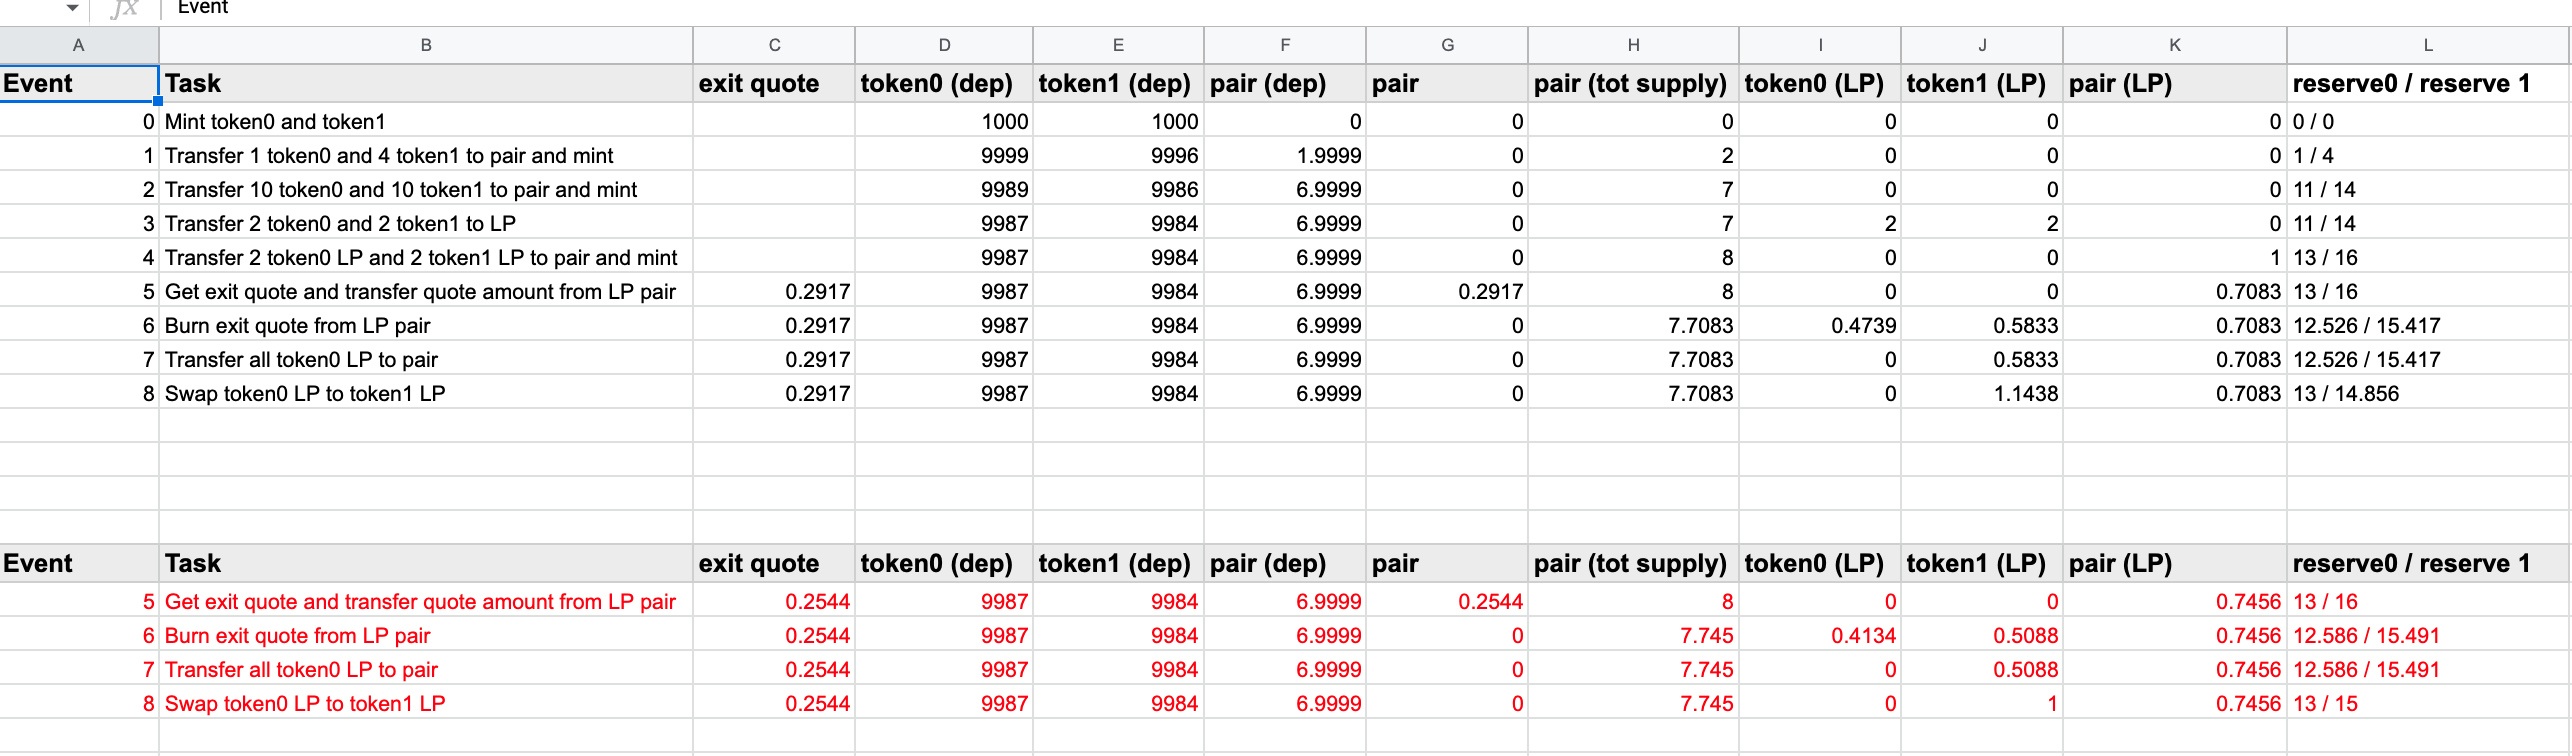

In [27]:
Image("images/jupyter/uniswap_v2/contract_output.png",  width = 900, height = 300)